# Normalization

In [1]:
import matplotlib.pyplot as plt
import re
import nltk
import networkx as nx
from node2vec import Node2Vec
from sklearn.manifold import TSNE
from scipy import spatial
import numpy as np

In [ ]:
!rm -f gazeta_train.jsonl
!wget 'https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.jsonl'
!rm -f gazeta_val.jsonl
!wget 'https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.jsonl'
!rm -f gazeta_test.jsonl
!wget 'https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.jsonl'

In [ ]:
import json

train=[]
with open("gazeta_train.jsonl", "r") as ftrain:
    for line in ftrain:
        train.append(json.loads(line))
val=[]
with jsonlines.open("gazeta_val.jsonl", "r") as fval:
    for line in fval.iter():
        val.append(line)
test=[]
with jsonlines.open("gazeta_test.jsonl", "r") as ftest:
    for line in ftest.iter():
        test.append(line)

In [2]:
"""import jsonlines
train=[]
with jsonlines.open("gazeta_train.jsonl") as ftrain:
    for line in ftrain.iter():
        train.append(line)
val=[]
with jsonlines.open("gazeta_val.jsonl") as fval:
    for line in fval.iter():
        val.append(line)
test=[]
with jsonlines.open("gazeta_test.jsonl") as ftest:
    for line in ftest.iter():
        test.append(line)
"""

In [20]:
print(train[0].keys())

dict_keys(['date', 'url', 'summary', 'title', 'text'])


Я буду использовать датасет русских статей с уже готовой суммаризацией для обучения алгоритмов.

In [132]:
def porter_stemmer(word):     
    # Helper regex strings.

    def _find_rv(word):
        _vowel = "[аеиоуыэюя]"
        _re_rv = re.compile(_vowel)
        rv_match = _re_rv.search(word)
        if not rv_match:
            return len(word)
        return rv_match.end()

    def _find_r2(word):
        _vowel = "[аеиоуыэюя]"
        _non_vowel = "[^аеиоуыэюя]"
        _re_r1 = re.compile(_vowel + _non_vowel)
        r1_match = _re_r1.search(word)
        if not r1_match:
            return len(word)
        r2_match = _re_r1.search(word, r1_match.end())
        if not r2_match:
            return len(word)
        return r2_match.end()

    def _cut(word, ending, pos):
        match = ending.search(word, pos)
        if match:
            try:
                ignore = match.group("ignore") or ""
            except IndexError:
                # No ignored characters in pattern.
                return True, word[:match.start()]
            else:
                # Do not cut ignored part.
                return True, word[:match.start() + len(ignore)]
        else:
            return False, word

    def _step_1(word, rv_pos):
        _re_perfective_gerund = re.compile(r"(((?P<ignore>[ая])(в|вши|вшись))|(ив|ивши|ившись|ыв|ывши|ывшись))$")
        _re_adjective = re.compile(r"(ее|ие|ые|ое|ими|ыми|ей|ий|ый|ой|ем|им|ым|ом|его|ого|ему|ому|их|ых|"
                                   r"ую|юю|ая|яя|ою|ею)$")
        _re_participle = re.compile(r"(((?P<ignore>[ая])(ем|нн|вш|ющ|щ))|(ивш|ывш|ующ))$")
        _re_reflexive = re.compile(r"(ся|сь)$")
        _re_verb = re.compile(
            r"(((?P<ignore>[ая])(ла|на|ете|йте|ли|й|л|ем|н|ло|но|ет|ют|ны|ть|ешь|"
            r"нно))|(ила|ыла|ена|ейте|уйте|ите|или|ыли|ей|уй|ил|ыл|им|ым|ен|ило|"
            r"ыло|ено|ят|ует|уют|ит|ыт|ены|ить|ыть|ишь|ую|ю))$")
        _re_noun = re.compile(
            r"(а|ев|ов|ие|ье|е|иями|ями|ами|еи|ии|и|ией|ей|ой|ий|й|иям|ям|ием|ем|"
            r"ам|ом|о|у|ах|иях|ях|ы|ь|ию|ью|ю|ия|ья|я)$")
        
        match, word = _cut(word, _re_perfective_gerund, rv_pos)
        if match:
            return word
        _, word = _cut(word, _re_reflexive, rv_pos)
        match, word = _cut(word, _re_adjective, rv_pos)
        if match:
            _, word = _cut(word, _re_participle, rv_pos)
            return word
        match, word = _cut(word, _re_verb, rv_pos)
        if match:
            return word
        _, word = _cut(word, _re_noun, rv_pos)
        return word

    def _step_2(word, rv_pos):
        _re_i = re.compile(r"и$")
        _, word = _cut(word, _re_i, rv_pos)
        return word

    def _step_3(word, r2_pos):
        _re_derivational = re.compile(r"(ост|ость)$")
        _, word = _cut(word, _re_derivational, r2_pos)
        return word

    def _step_4(word, rv_pos):
        _re_superlative = re.compile(r"(ейш|ейше)$")
        _re_nn = re.compile(r"((?<=н)н)$")
        _re_ = re.compile(r"ь$")
        _, word = _cut(word, _re_superlative, rv_pos)
        match, word = _cut(word, _re_nn, rv_pos)
        if not match:
            _, word = _cut(word, _re_, rv_pos)
        return word
    rv_pos, r2_pos = _find_rv(word), _find_r2(word)
    word = _step_1(word, rv_pos)
    word = _step_2(word, rv_pos)
    word = _step_3(word, r2_pos)
    word = _step_4(word, rv_pos)
    return word


In [133]:
nltk.download('stopwords')
from nltk.corpus import stopwords

def preprocessing(original_text):
    stop_words = set(stopwords.words('russian'))
    lower_text = original_text.lower()  # нижний регистр
    no_number_text = re.sub(r'\d+','',lower_text)  # убираем числа
    no_punc_text = re.sub(r'[^\w\s]','', no_number_text)  # убираем пунктуацию
    no_wspace_text = no_punc_text.strip()  # убираем пробелы
    lst_string = [no_wspace_text][0].split()  # строка в список
    no_stopwords_string=""
    no_stopwords_list=[]         # убираем стоп-слова
    for i in lst_string:
        if not i in stop_words:
            no_stopwords_string += i+' '
            no_stopwords_list.append(porter_stemmer(i))
    no_stopwords_list = no_stopwords_list[:-1]   #убираем последний пробел
    return no_stopwords_list


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В результате нормализации получаем список основ слов без суффиксов и окончаний, которые входят в текст. В нем отсутствуют "стоп-слова": предлоги, частицы, междометия и тд.

In [57]:
# example
print(preprocessing(train[0]['text']))
print(train[0]['text'])

['сегодн', 'транспортн', 'налог', 'начисля', 'зависим', 'мощност', 'автомобил', 'прич', 'цен', 'сильн', 'машин', 'выш', 'малолитражек', 'такж', 'ставк', 'налог', 'могут', 'корректирова', 'региональн', 'власт', 'согласн', 'налогов', 'кодекс', 'базов', 'тариф', 'установлен', 'правительств', 'уменьш', 'пят', 'увелич', 'сбор', 'идут', 'региональн', 'бюджет', 'откуд', 'растека', 'общ', 'нужд', 'транспортн', 'налог', 'основн', 'источник', 'бюджетн', 'доход', 'предлага', 'направ', 'исключительн', 'дорожн', 'фонд', 'автомобилист', 'будут', 'понима', 'плат', 'дорожник', 'будут', 'имет', 'гарантирова', 'доход', 'кром', 'налог', 'дорожн', 'фонд', 'будут', 'пополня', 'счет', 'бюджетн', 'средств', 'проезд', 'платн', 'дорог', 'транспортн', 'налог', 'предлага', 'завуалирова', 'акциз', 'бензин', 'привычн', 'раздража', 'сист', 'ежегодн', 'оплат', 'квитанц', 'предлага', 'измен', 'включ', 'налог', 'стоимост', 'топлив', 'минэкономразвит', 'говор', 'удвоен', 'акциз', 'котор', 'сегодн', 'составля', 'рубл', 

# Text-to-Network Conversion

Построим граф с весами ребер 1,2,3. Вес 3 означает, что в тексте слова стоят рядом, 2 - между словами-вершинами в тексте стоит еще слово и 1 - слова разделяют другие 2 слова.

In [164]:
def graphMaker(no_stopwords_list):
    G = nx.Graph()
    G.add_nodes_from(no_stopwords_list)
    for edge in range(0, len(no_stopwords_list[:-4])):
        G.add_edge(no_stopwords_list[edge], no_stopwords_list[edge+1], weight = 3)
        G.add_edge(no_stopwords_list[edge], no_stopwords_list[edge+2], weight = 2)
        G.add_edge(no_stopwords_list[edge], no_stopwords_list[edge+3], weight = 1)
    G.add_edge(no_stopwords_list[-4], no_stopwords_list[-3], weight = 3)
    G.add_edge(no_stopwords_list[-4], no_stopwords_list[-2], weight = 2)
    G.add_edge(no_stopwords_list[-4], no_stopwords_list[-1], weight = 1)
    G.add_edge(no_stopwords_list[-3], no_stopwords_list[-2], weight = 3)
    G.add_edge(no_stopwords_list[-3], no_stopwords_list[-1], weight = 2)
    G.add_edge(no_stopwords_list[-2], no_stopwords_list[-1], weight = 3)
    return G

In [153]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
def preprocessing2(original_text):
    stop_words = set(stopwords.words('english'))
    lower_text = original_text.lower()  # нижний регистр
    no_number_text = re.sub(r'\d+','',lower_text)  # убираем числа
    no_punc_text = re.sub(r'[^\w\s]','', no_number_text)  # убираем пунктуацию
    no_wspace_text = no_punc_text.strip()  # убираем пробелы
    lst_string = [no_wspace_text][0].split()  # строка в список
    no_stopwords_string=""
    no_stopwords_list=[]         # убираем стоп-слова
    stemmer = PorterStemmer()
    for i in lst_string:
        if not i in stop_words:
            no_stopwords_string += i+' '
            no_stopwords_list.append(stemmer.stem(i))
    no_stopwords_list = no_stopwords_list[:-1]   #убираем последний пробел
    return no_stopwords_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['exampl', 'automat', 'summaris', 'use', 'gener']


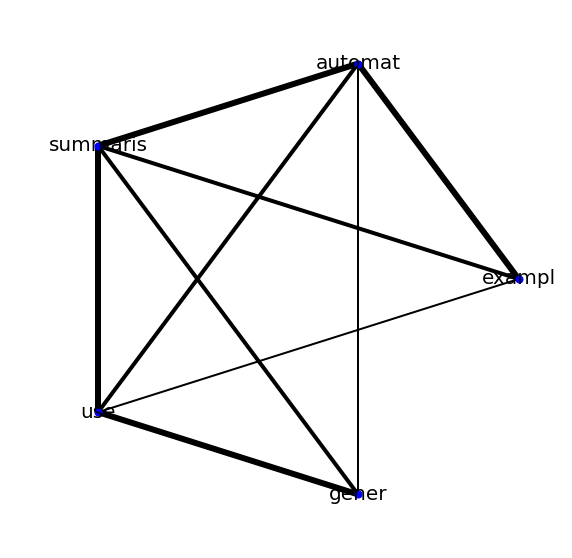

In [165]:
sent = 'For example, automatic summarisation use to generate headlines'
arr = preprocessing2(sent)
print((arr))
E = graphMaker(arr)
plt.figure(figsize=(10,10))
edges=E.edges()
weights = [E[u][v]['weight']*2 for u,v in edges]
pos = nx.circular_layout(E)
nodes = nx.draw_networkx_nodes(E, pos, node_size=50, node_color='blue')
edges = nx.draw_networkx_edges(E, pos, node_size=50, width=weights)
nx.draw_networkx_labels(E, pos, font_size=20, font_family='sans-serif')

#nx.draw(G, pos, with_labels=False, node_size=20)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axis("off")
plt.show()

Визуализируем граф, построеный на небольшом тексте. На графе мы видим хабы - вершины с большим количеством ребер, то есть это слова, которые встречаются в тексте не раз и связаны с большим количеством других слов. Будем считать, что такие слова самые важные и формируют основной смысл текста. Видим,что иногда образуются петли, их можно убрать на этапе нормализации текста, однако они тоже вносят вклад в вес отдельного слова, поэтому их следует оставить.

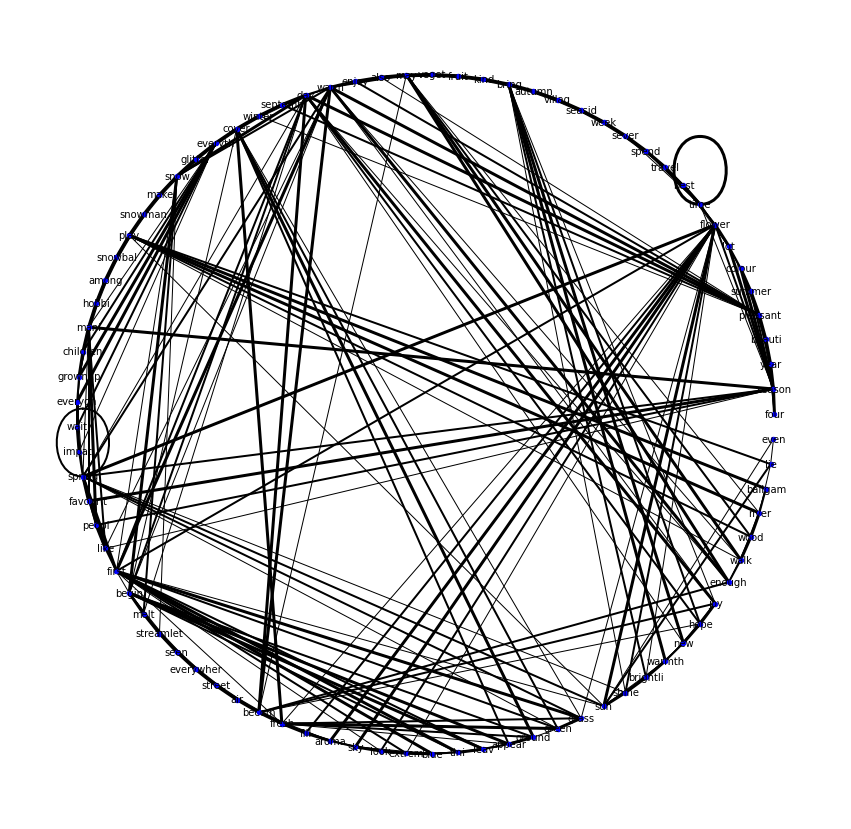

In [228]:
G = graphMaker(no_stopwords_list)
plt.figure(figsize=(15,15))
edges=G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
pos = nx.circular_layout(G)
nodes = nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=20, width=weights)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

#nx.draw(G, pos, with_labels=False, node_size=20)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axis("off")
plt.show()

# Extracting Most Influential Keywords Using Closeness, Betweenness and Degree Centrality

In [8]:
def degreeCentrality(G):
    max_degree = 0
    list_of_nodes = {}
    for i in list(G.nodes):
        list_of_nodes[i] = int(G.degree[i])
        if G.degree[i]>max_degree:
            max_degree=G.degree[i]
    return list_of_nodes

def betweennessCentrality(G):
    centrality = nx.betweenness_centrality(G)
    return centrality

def closenessCentrality(G):
    centrality = nx.closeness_centrality(G)
    return centrality

In [9]:
def small_preprosessing(original_text):
    nltk.download('punkt')
    text = re.sub(r'[\n\t]','', original_text)  #убираем все /n, /t
    main_sent_lst = nltk.sent_tokenize(text, language="russian") # список предложений из текста как в оригинале
    return main_sent_lst

In [10]:
def sentWeight(list_of_nodes, original_text):
    sent_weight=[]
    main_sent_lst = small_preprosessing(original_text)     # Разделяем текст на предложения
    #print(main_sent_lst)
    for i in range(len(main_sent_lst)):
        arr_sent = preprocessing(main_sent_lst[i])
        sum_sent=0
        amount=1
        for word in arr_sent:
            if word in list_of_nodes:
                sum_sent+=list_of_nodes[word]
                amount+=1
        sent_weight.append((main_sent_lst[i], i, sum_sent/amount))
    sent_weight.sort(key=lambda el: el[2], reverse=True)
    return sent_weight

In [98]:
def sumarCloseness(original_text, file):
    sent_weight=sentWeight(closenessCentrality(graphMaker(preprocessing(original_text))), original_text)
    sent_weight = sent_weight[0:5]      #суммаризация будет включать в себя 5 главных предложений их статьи
    sent_weight.sort(key=lambda el: el[1], reverse=False)
    sumar=[]
    for i in sent_weight:
        sumar.append(i[0])
    f=open(file, 'w')
    summar_str = ''
    for i in sumar:
        summar_str = summar_str + i
    text_with_sum = '{text: "'+ original_text + '", summary: "' + summar_str + '"}'
    f.write(text_with_sum)

def sumarBetweenness(original_text, file):
    sent_weight=sentWeight(betweennessCentrality(graphMaker(preprocessing(original_text))), original_text)
    sent_weight = sent_weight[0:5]      #суммаризация будет включать в себя 5 главных предложений их статьи
    sent_weight.sort(key=lambda el: el[1], reverse=False)
    sumar=[]
    for i in sent_weight:
        sumar.append(i[0])
    f=open(file, 'w')
    summar_str = ''
    for i in sumar:
        summar_str = summar_str + i
    text_with_sum = '{text: "'+ original_text + '", summary: "' + summar_str + '"}'
    f.write(text_with_sum)

def sumarDegree(original_text, file):
    sent_weight=sentWeight(degreeCentrality(graphMaker(preprocessing(original_text))), original_text)
    sent_weight = sent_weight[0:5]      #суммаризация будет включать в себя 5 главных предложений их статьи
    sent_weight.sort(key=lambda el: el[1], reverse=False)
    sumar=[]
    for i in sent_weight:
        sumar.append(i[0])
    f=open(file, 'w')
    summar_str = ''
    for i in sumar:
        summar_str = summar_str + i
    text_with_sum = '{text: "'+ original_text + '", summary: "' + summar_str + '"}'
    f.write(text_with_sum)


In [99]:
sumarCloseness(train[0]['text'], "Closeness.txt")
sumarBetweenness(train[0]['text'], "Betweennness.txt")
sumarDegree(train[0]['text'], "Degree.txt")

sumarCloseness(train[1]['text'], "Closeness1.txt")
sumarBetweenness(train[1]['text'], "Betweenness1.txt")
sumarDegree(train[1]['text'], "Degree1.txt")

sumarCloseness(train[2]['text'], "Closeness2.txt")
sumarBetweenness(train[2]['text'], "Betweenness2.txt")
sumarDegree(train[2]['text'], "Degree2.txt")

sumarCloseness(train[3]['text'], "Closeness3.txt")
sumarBetweenness(train[3]['text'], "Betweenness3.txt")
sumarDegree(train[3]['text'], "Degree3.txt")

sumarCloseness(train[4]['text'], "Closeness4.txt")
sumarBetweenness(train[4]['text'], "Betweenness4.txt")
sumarDegree(train[4]['text'], "Degree4.txt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Крис

Результат использования различных центральностей отличается лишь на пару предложений, то есть качества суммаризации почти не улучшает. Исходный текст и резулитат суммаризации можно посмотреть в файлах Closeness.txt, Betweeness.txt, Degree.txt

1 проблема - прямая речь. ее нельзя отрывать от исходного предложения, так же нужно ее обезопасить от разделения на отдельные предложения, всю прямую речь нужно рассматривать вместе.

2 проблема - разделения мысли. В каждом абзаце своя мысль. Лучше убирать целые не очень важные абзацы, а потом в каждом из них оставлять самые важные предложения. А также отсутствие связности в предложениях, поэтому их сложно читать человеку.

3 проблема - отсутствие хорошего стриммера для выделения основ русских слов. Русский язык разнообразен и часто меняются не только окончания, суффиксы и приставки, но и сама основа, или добавление нескольких суффиксов усложняет стримминг слова. Здесь использовался Стриммер Портера, но и он для русского языка не идеален. Например, "руб." и "рублей" - две разные основы "руб" и "рубл", правильнее было бы сократить все в до основы "руб".

# Суммаризация с использованием Node2Ves

In [134]:
original_text = train[0]['text']
G = graphMaker(preprocessing(train[0]['text']))
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/252 [00:00<?, ?it/s]

In [16]:
vectors=[]
for i in no_stopwords_list:
    vectors.append(model.wv[i])

In [73]:
def cos_equal_matrix(size, matrix):            # составляем матрицу схожести предложений, которая использует 
    distances = np.zeros((size,size))          # формулу косинусного сходства для каждой пары предложений
    for first in range(size):
        for sec in range(size):
            distance = spatial.distance.cosine(matrix[first],matrix[sec])
            distances[first,sec] = distance
    return distances

In [143]:
def graphMaker2(matrix):
    G = nx.Graph()
    nodes = [i for i in range(len(matrix))]
    G.add_nodes_from(nodes)
    for row in range(len(matrix)):
        for el in range(row + 1, len(matrix)):
            G.add_edge(row, el, weight = matrix[row][el])
    return G

def sentWeight2(original_text):
    G = graphMaker(preprocessing(original_text))
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    arr = small_preprosessing(original_text)
    
    def vec_from_sent(sent_from_text):                # Создаем вектор предложения - сумма всех векторов входящих слов,
        vec=[0] * 64                        # деленная на длину предложения
        sent = preprocessing(sent_from_text)
        for i in sent:
            vec+=model.wv[i]
        for el in range(len(vec)):
            vec[el]=vec[el]/len(sent)
        return vec
    
    def matrix_from_text(arr):                # создаем матрицу из всех предложений на основе входящих в них слов
        matrix=[]
        for i in arr:
            matrix.append(vec_from_sent(i))
        print(matrix)
        return matrix
    
    summilarity_matrix=cos_equal_matrix(len(arr), matrix_from_text(arr))
    G = graphMaker2(summilarity_matrix)
    weights = [0] * len(G.nodes())
    for u, v in G.edges():
        weights[u] += G[u][v]['weight']
        weights[v] += G[u][v]['weight']
    result = []
    for i in range(len(weights)):
        result.append((i, weights[i], arr[i]))
    result.sort(key=lambda el: el[1], reverse=False)
    return result

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Сегодня транспортный налог начисляется в зависимости от мощности автомобиля, причем цена для «сильных» машин выше, чем для малолитражек.
[ 0.10725172 -0.14092675  0.24572356 -0.01925438 -0.03644003 -0.06368604
 -0.13342492  0.03364458 -0.11597014  0.06029432  0.04909206 -0.0754635
 -0.02402165  0.03757548 -0.08346001  0.47155419  0.02771755 -0.01255216
  0.4150152   0.16825339  0.20102386 -0.03625383 -0.17816311 -0.40186991
  0.08509354  0.21109807 -0.09002378  0.11136605  0.12369091 -0.03899834
  0.43474706 -0.14869694  0.22315159  0.1934028  -0.071738    0.03634698
  0.08946463  0.11515659 -0.01381844  0.1318974   0.10573586 -0.13322493
 -0.09816776  0.07025732  0.15090313 -0.14690025 -0.04848623 -0.01539156
 -0.06219693 -0.07460719  0.02681868  0.1672423   0.29672213  0.21779863
  0.13282802 -0.02136416  0.35827133  0.01044136 -0.13679303  0.16977587
 -0.21631511 -0.26373362 -0.18040781 -0.17886431]
[array([ 0.10725172, -0.14092675,  0.24572356, -0.01925438, -0.03644003,
       -0.0

[[0.         0.67145981 0.59881643 ... 0.76265656 0.79068726 0.81195285]
 [0.67145981 0.         0.60150819 ... 0.47156642 0.78362558 0.47332468]
 [0.59881643 0.60150819 0.         ... 0.59344633 0.46406388 0.48081899]
 ...
 [0.76265656 0.47156642 0.59344633 ... 0.         0.62461259 0.5876841 ]
 [0.79068726 0.78362558 0.46406388 ... 0.62461259 0.         0.27072522]
 [0.81195285 0.47332468 0.48081899 ... 0.5876841  0.27072522 0.        ]]


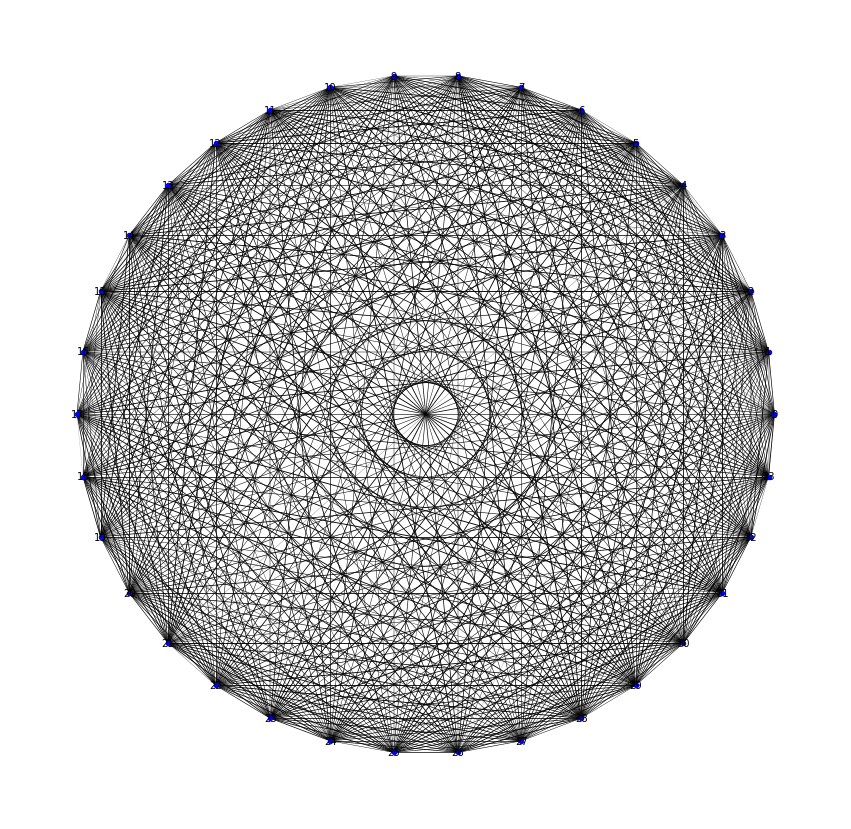

In [145]:
arr = small_preprosessing(original_text)
print(arr[0])
print(vec_from_sent(arr[0]))
print(matrix_from_text(arr))
summilarity_matrix=cos_equal_matrix(len(arr), matrix_from_text(arr))
print(summilarity_matrix)
G = graphMaker2(summilarity_matrix)
plt.figure(figsize=(15,15))
edges=G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
pos = nx.circular_layout(G)
nodes = nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=20, width=weights)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

#nx.draw(G, pos, with_labels=False, node_size=20)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axis("off")
plt.show()

In [85]:
original_text = train[0]['text']
result = sentWeight2(original_text)
print(result)

Computing transition probabilities:   0%|          | 0/252 [00:00<?, ?it/s]

[(0, 19.33483407754906, 'Сегодня транспортный налог начисляется в зависимости от мощности автомобиля, причем цена для «сильных» машин выше, чем для малолитражек.'), (9, 19.64645080330613, 'Владельцам многосильных автомобилей, которые сегодня отдают в год по 45–50 тысяч за машину, нововведение явно выгодно.'), (27, 19.922675019379813, 'Но даже с учетом всех оговорок отмена транспортного налога — это важный и сильный политический шаг, который поможет снять напряжение в регионах.'), (7, 20.06365289055266, 'Минэкономразвития говорит об удвоении акцизы, которая сегодня составляет 3,32 рубля за литр 92-го и 95-го бензина.'), (16, 20.156864867114187, 'обойдется в 11155 «налоговых» рублей – на 6800 рублей дороже, чем при существующей ставке налогообложения, а вот налог на пожилой Mercedes-Benz S420 в кузове W140 при новой системе снизится почти вдвое.'), (14, 20.2861610054473, 'Если цена бензина вырастет на 3,32 рубля, то владелец вазовской «девятки», потребляющей на 100 км в городе около 10 л

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


По резулитатам работы алгоритма оценки значимости видно, что самые значимые предложения - это те, у которых коэффициент схожести наименьший. На основе 5 предложений с наименьшим коэффициентом схожести составим суммаризацию.

In [100]:
def summarNode2Vec(original_text, file):
    result = sentWeight2(original_text)
    f=open(file, 'w')
    summar_str = ''
    for i, k, sent in result[0:5]:
        summar_str = summar_str + sent
    text_with_sum = '{text: "'+ original_text + '", summary: "' + summar_str + '"}'
    f.write(text_with_sum)

In [101]:
summarNode2Vec(train[0]['text'], "Node2VecSum.txt")
summarNode2Vec(train[1]['text'], "Node2VecSum1.txt")
summarNode2Vec(train[2]['text'], "Node2VecSum2.txt")
summarNode2Vec(train[3]['text'], "Node2VecSum3.txt")
summarNode2Vec(train[4]['text'], "Node2VecSum4.txt")

Computing transition probabilities:   0%|          | 0/252 [00:00<?, ?it/s]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Computing transition probabilities:   0%|          | 0/311 [00:00<?, ?it/s]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Computing transition probabilities:   0%|          | 0/169 [00:00<?, ?it/s]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Computing transition probabilities:   0%|          | 0/217 [00:00<?, ?it/s]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Computing transition probabilities:   0%|          | 0/195 [00:00<?, ?it/s]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Результат суммаризации отличается от составленной на графе, но без помощи Node2Vec. Сложно сказать какой из них лучше.

Вывод:

# Абстрактивная суммаризация

Предыдущий алгоритм просто составлял набор вырезанных предложений, которые несут в себе самую важную информацию, однако предложения не были связаны словами связками, логическим переходом мысли, то есть человеку такой "текст" читать неприятно и непонятно. Для того, чтобы сделать суммаризацию более осмысленной и приятной для чтения человеку используем нейронные сети.

In [26]:
print(train[0].keys())
print(val[0].keys())
print(test[0].keys())

dict_keys(['date', 'url', 'summary', 'title', 'text'])
dict_keys(['date', 'url', 'summary', 'title', 'text'])
dict_keys(['date', 'url', 'summary', 'title', 'text'])


In [27]:
print(train[0]['text'])

Сегодня транспортный налог начисляется в зависимости от мощности автомобиля, причем цена для «сильных» машин выше, чем для малолитражек. Также ставку налога могут корректировать региональные власти: согласно Налоговому кодексу, базовый тариф, установленный правительством, может быть уменьшен в пять раз или увеличен до 10 раз. Сборы идут в региональные бюджеты, откуда растекаются на общие нужды. Транспортный налог — один из основных источников бюджетных доходов — предлагается направить исключительно на дорожные фонды. Так, автомобилисты будут понимать, за что они платят, а дорожники будут иметь гарантированный доход. Кроме налога дорожные фонды будут пополняться за счет бюджетных средств и проезда по платным дорогам. Более того, транспортный налог предлагается завуалировать в акцизы на бензин. Привычную и раздражающую систему ежегодной оплаты квитанции предлагается изменить, включив налог в стоимость топлива. Минэкономразвития говорит об удвоении акцизы, которая сегодня составляет 3,32 

In [30]:
print(train[0]['summary'])

С 2011 года правительство отменяет самый раздражающий граждан налог – транспортный. Но поборы автомобилистов не прекратятся – налоги завуалируют в бензиновые акцизы и платные дороги, а цены на товары подскочат. Зато теперь собираемые деньги обещают пустить только на строительство и содержание дорог.


# Knowledge graph